# Purpose of tis Notebook

This notebook is used for training the test models. It inputs numpy arrays that are extracted by extract_arrays.ipynb. tHe paths to these should be entered in the FEATURES_PATH and LABELS_PATH variables.

The notebook trains the models and print the evaluate results. It also saves the models for reuse. 




In [11]:
import pandas as pd
import tensorflow as tf
import numpy as np
import datetime as dt
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt

In [12]:
FEATURES_PATH = "data/my_20_sec_features-2022_05_26__19_44_46.npy"
LABELS_PATH = "data/my_20_sec_labels-2022_05_26__19_44_46.npy"

SEED = 42

In [13]:
with open(FEATURES_PATH, 'rb') as f:
    features = np.load(f)
features.shape

(3000, 200, 150, 2)

In [14]:
with open(LABELS_PATH, 'rb') as f:
    labels = np.load(f)
labels.shape

(3000,)

In [15]:
labels = [label.split('-')[0] for label in labels]
labels[:10]

['www.youtube.com',
 'www.bbc.co.uk',
 'www.facebook.com',
 'www.twitter.com',
 'www.wikipedia.com',
 'www.ebay.co.uk',
 'www.google.com',
 'www.google.com',
 'www.bbc.co.uk',
 'www.ebay.co.uk']

In [16]:
label_binariser = LabelBinarizer()
labels_encoded = label_binariser.fit_transform(labels)
labels_encoded.shape

(3000, 10)

In [10]:
cnn = keras.Sequential()

cnn.add(layers.InputLayer((200,150,2)))
cnn.add(layers.Conv2D(filters=10, kernel_size=(3,3)))
# cnn.add(layers.MaxPool2D(pool_size=(2,2), padding = 'same', data_format = "channels_last"))
cnn.add(layers.Conv2D(filters=24, kernel_size=(3,3)))
# cnn.add(layers.MaxPool2D(pool_size=(2,2), padding = 'same', data_format = "channels_last"))
cnn.add(layers.Conv2D(filters=32, kernel_size=(3,3)))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(64, activation="relu"))
cnn.add(layers.Dense(labels_encoded.shape[1], activation="softmax"))

cnn.summary()

2022-05-26 19:45:34.636337: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 148, 10)      190       
                                                                 
 conv2d_1 (Conv2D)           (None, 196, 146, 24)      2184      
                                                                 
 conv2d_2 (Conv2D)           (None, 194, 144, 32)      6944      
                                                                 
 flatten (Flatten)           (None, 893952)            0         
                                                                 
 dense (Dense)               (None, 64)                57212992  
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 57,222,960
Trainable params: 57,222,960
No

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

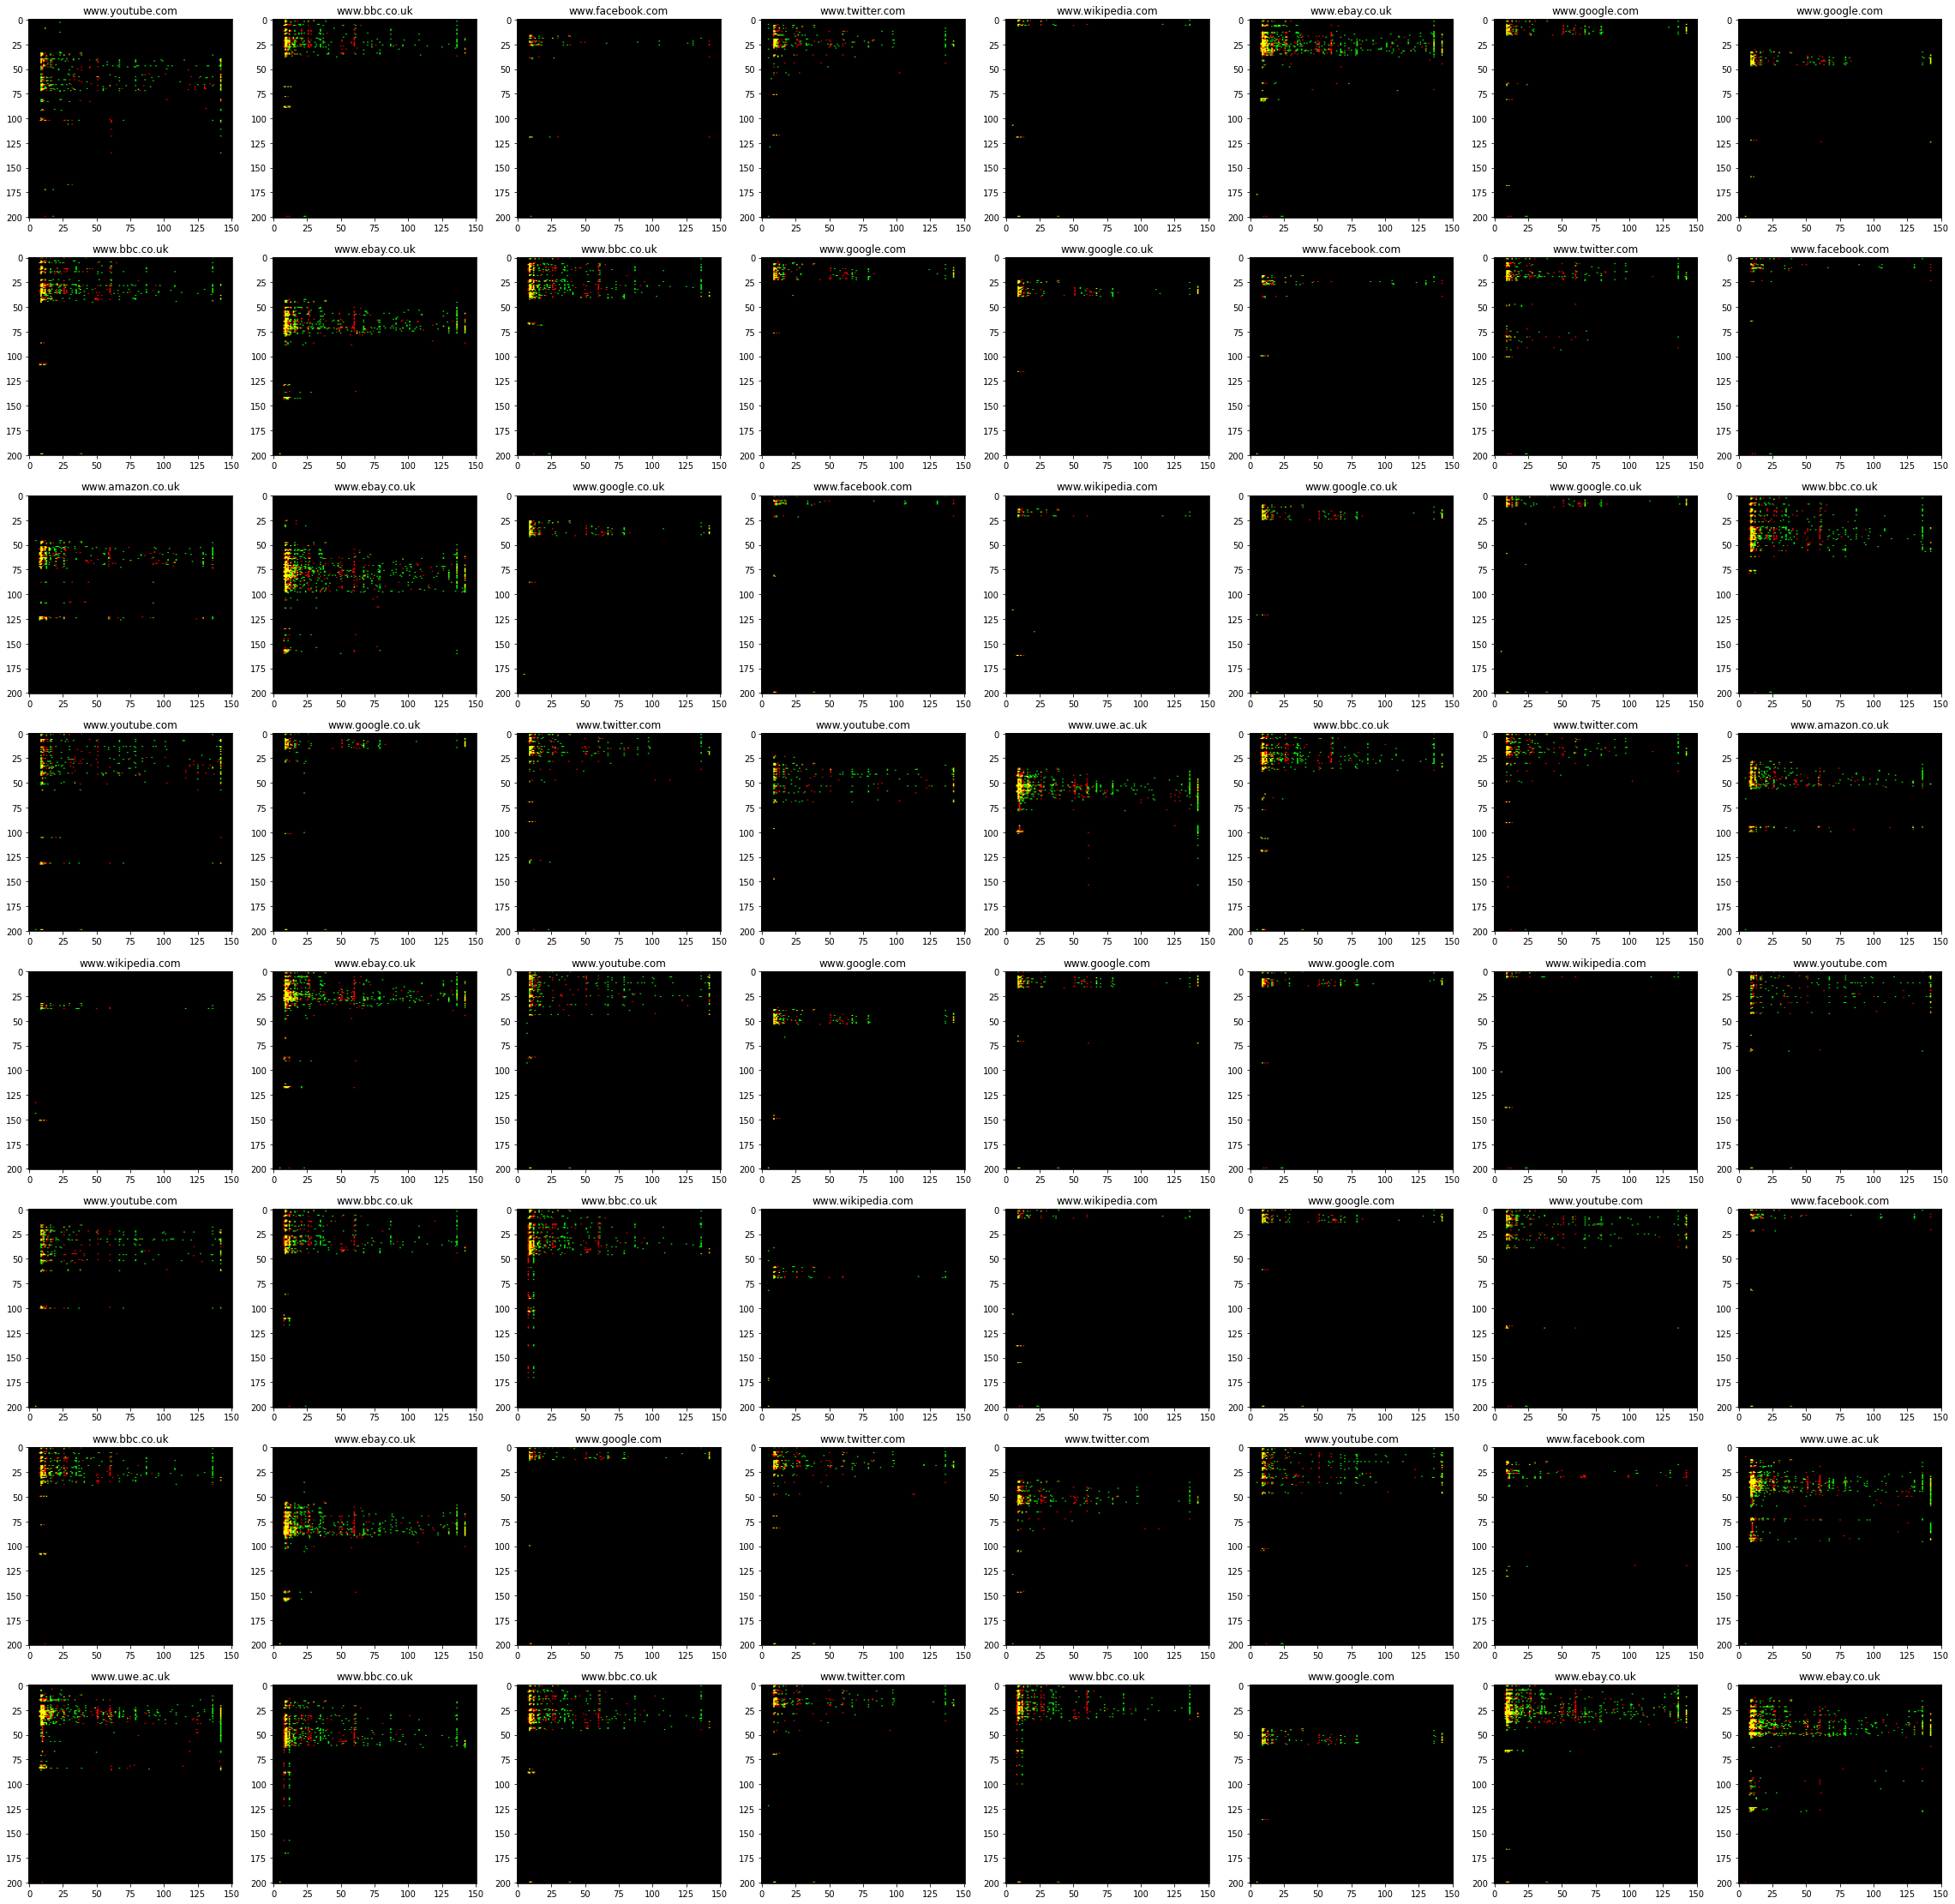

In [17]:
plt.figure(figsize=(40,40))

for i in range(64):
    plt.subplot(8,8,i +1)
    plt.imshow(np.pad(features[i], (0,1)) * 255, aspect="auto")
    plt.title(f"{labels[i]}")

In [18]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels_encoded,
    test_size=0.25,
    shuffle=True,
    random_state=SEED
)

In [19]:
max = features_train.max()

features_train = features_train/max
features_test = features_test/max

print(max)

709.0


In [20]:
early_stopping_callback = callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

In [15]:
# opt = tf.keras.optimizers.Adam(learning_rate=1)
# cnn.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
# cnn_history = cnn.fit(features_train, labels_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping_callback])

In [16]:
# cnn.evaluate(features_test, labels_test)

In [17]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(10,5)) 
    (ax1, ax2) = axs
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='validation')

    ax1.legend(loc="upper right")
    ax1.set_xlabel("# of epochs")
    ax1.set_ylabel("loss")

    ax2.plot(history.history['accuracy'], label='train')
    ax2.plot(history.history['val_accuracy'], label='validation')

    ax2.legend(loc="upper right")
    ax2.set_xlabel("# of epochs")
    ax2.set_ylabel("accuracy")

    print("Final training accuracy:", history.history['accuracy'][-1])
    print("Final validation accuracy:", history.history['val_accuracy'][-1])

In [18]:
# plot_history(cnn_history)

In [22]:
def plot_results(model):
    predictions =  model.predict(features_test)
    cm = confusion_matrix(labels_test, predictions, labels=model.classes_, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_binariser.inverse_transform(model.classes_))
    disp.plot(xticks_rotation=270, values_format=".1f")
    plt.show()
    print(classification_report(labels_test, predictions))

In [23]:
y_true = np.argmax(labels_test, axis=1)
unique_y = np.unique(y_true)

In [21]:
# predictions =  np.argmax(cnn.predict(features_test), axis=1)

In [24]:
def plot_results(model):
    fig, ax = plt.subplots(figsize=(12, 12))
    y_true = np.argmax(labels_test, axis=1)
    predictions =  np.argmax(model.predict(features_test), axis=1)
    cm = confusion_matrix(y_true, predictions, normalize='true')
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=[label_binariser.classes_[x] for x in range(unique_y.min(), len(unique_y))]
        )
    disp.plot(xticks_rotation=270, values_format=".1f", ax=ax)
    plt.show()
    print(classification_report(y_true, predictions))

In [23]:
# plot_results(cnn)

In [24]:
def create_convlstm_model():

    model = keras.Sequential()

    model.add(layers.ConvLSTM1D(
        filters = 4,
        kernel_size=5,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True,
        input_shape = (features_train[0].shape)
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))
    # Dropout layer for sequence data



    model.add(layers.ConvLSTM1D(
        filters=10,
        kernel_size=15,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))


    model.add(layers.ConvLSTM1D(
        filters=14,
        kernel_size=10,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    model.add(layers.TimeDistributed(layers.Dropout(0.2)))


    model.add(layers.ConvLSTM1D(
        filters=16,
        kernel_size=10,
        activation="tanh",
        data_format="channels_last",
        recurrent_dropout=0.2,
        return_sequences=True
    ))

    model.add(layers.MaxPooling2D(
        pool_size = (1, 2),
        padding = 'same',
        data_format = "channels_last"
    ))

    # model.add(TimeDistributed(Dropout(0.2)))


    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation="relu"))
    
    model.add(layers.Dense(labels_encoded.shape[1], activation="softmax"))

    model.summary()

    return model

In [25]:
convlstm_model = create_convlstm_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 200, 146, 4)       496       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 73, 4)       0         
 )                                                               
                                                                 
 time_distributed (TimeDistr  (None, 200, 73, 4)       0         
 ibuted)                                                         
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 200, 59, 10)       8440      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 200, 30, 10)      0         
 2D)                                                             
                                                      

In [26]:
convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
convlstm_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=16, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
113/113 [==============================] - 305s 3s/step - loss: 2.3073 - accuracy: 0.1156 - val_loss: 2.3034 - val_accuracy: 0.0822
Epoch 2/50
113/113 [==============================] - 279s 2s/step - loss: 2.3036 - accuracy: 0.1139 - val_loss: 2.3065 - val_accuracy: 0.0822
Epoch 3/50
113/113 [==============================] - 277s 2s/step - loss: 2.3007 - accuracy: 0.1256 - val_loss: 2.3020 - val_accuracy: 0.0978
Epoch 4/50
113/113 [==============================] - 284s 3s/step - loss: 2.2052 - accuracy: 0.1611 - val_loss: 2.1376 - val_accuracy: 0.3022
Epoch 5/50
113/113 [==============================] - 281s 2s/step - loss: 2.0791 - accuracy: 0.2122 - val_loss: 2.0451 - val_accuracy: 0.1978
Epoch 6/50
113/113 [==============================] - 299s 3s/step - loss: 1.8440 - accuracy: 0.3133 - val_loss: 1.6529 - val_accuracy: 0.3889
Epoch 7/50
113/113 [==============================] - 297s 3s/step - loss: 1.2184 - accuracy: 0.5339 - val_loss: 0.6850 - val_accuracy: 0.7511

Final training accuracy: 0.9649999737739563
Final validation accuracy: 0.9866666793823242


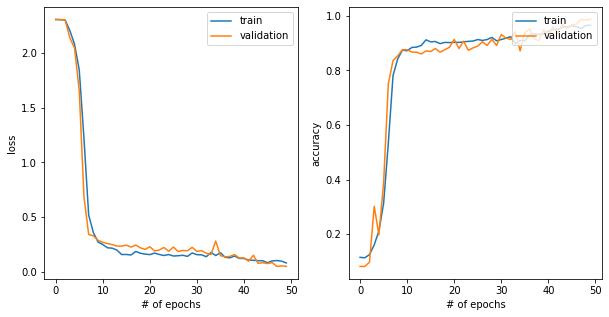

In [27]:
plot_history(convlstm_history)

In [27]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)
loss, acc = model_evaluation_history
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_datetime = dt.datetime.now()
current_datetime_string = dt.datetime.strftime(current_datetime, date_time_format)
model_file_name =f"convlstm_model_Datetime_{current_datetime_string}__loss_{loss}_acc_{acc}.h5"
convlstm_model.save(os.path.join("models", model_file_name))

24/24 [==============================] - 9s 336ms/step - loss: 0.0855 - accuracy: 0.9907


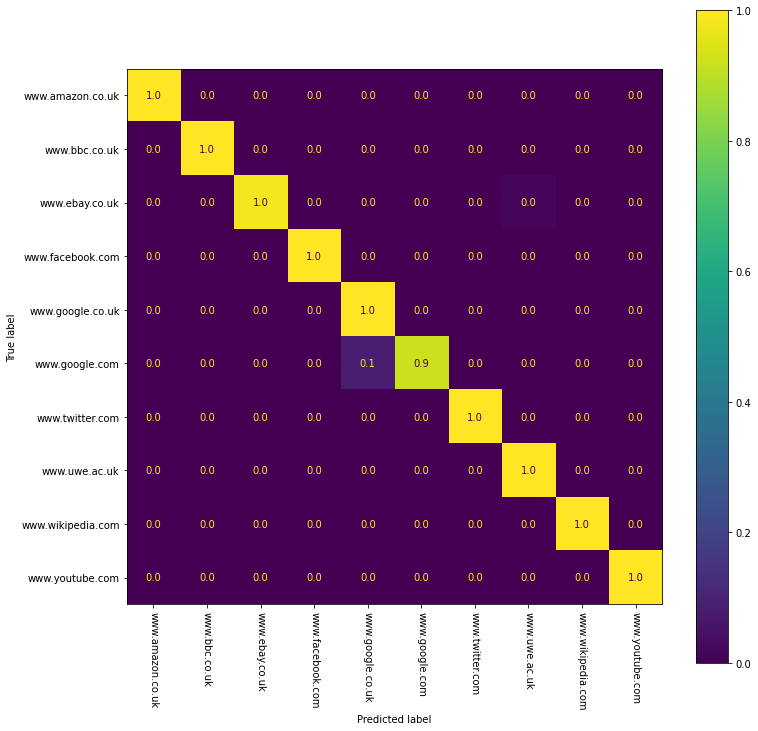

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        81
           1       1.00      1.00      1.00        63
           2       1.00      0.99      0.99        73
           3       1.00      1.00      1.00        79
           4       0.92      1.00      0.96        65
           5       1.00      0.92      0.96        79
           6       1.00      1.00      1.00        76
           7       0.99      1.00      0.99        68
           8       1.00      1.00      1.00        84
           9       1.00      1.00      1.00        82

    accuracy                           0.99       750
   macro avg       0.99      0.99      0.99       750
weighted avg       0.99      0.99      0.99       750



In [29]:
plot_results(convlstm_model)

In [10]:
def create_lrcn_model():

    model = keras.Sequential()

    model.add(
        layers.TimeDistributed(
            layers.Conv1D(
                filters=16,
                kernel_size=3,
                padding="same",
                activation="relu"
            ),
        input_shape=(features_train[0].shape)
        )
    )
  
    model.add(
        layers.TimeDistributed(
            layers.Dropout(0.25)
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Conv1D(
                filters=32,
                kernel_size=3,
                padding="same",
                activation="relu"
            )
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Dropout(0.25)
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Conv1D(
                filters=64,
                kernel_size=3,
                padding="same",
                activation="relu"
            )
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Dropout(0.25)
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Conv1D(
                filters=64,
                kernel_size=3,
                padding="same",
                activation="relu"
            )
        )
    )

    model.add(
        layers.TimeDistributed(
            layers.Flatten()
        )
    )

    model.add(
        layers.LSTM(32)
    )

    model.add(
        layers.Dense(
            labels_encoded.shape[1],
            activation="softmax"
        )
    )

    model.summary()

    return model

In [31]:
# lrcn_model = create_lrcn_model()

In [32]:
# lrcn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
# lrcn_history = lrcn_model.fit(x=features_train, y=labels_train, epochs=30, batch_size=16, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

In [33]:
# model_evaluation_history = lrcn_model.evaluate(features_test, labels_test)

In [34]:
# plot_history(lrcn_history)

In [35]:
# plot_results(lrcn_model)